# Shor's algorithm

Shor's algorithm, named after mathematician Peter Shor, is a quantum algorithm developed in 1994. It is designed to solve the problem of integer factorization on a quantum computer. In simple terms, the algorithm aims to find the prime factors of a given integer, N.



## Overview

*Lemma*: Factoring is equivalent to finding a nontrivial squareroot of 1 mod N.

## Problem Statement

Traditional or classical algorithms for factorization require exponential time as the size of the number increases, making them computationally expensive for large numbers. 


**Complexity:**

- Complexity on quantum computer: $\quad \mathcal{O}\;\Big((\log N)^2(\log \log N)(\log \log \log N)\Big)$

- Complexity on classical computer: $\quad \mathcal{O}\; \Big(e^{1.9(\log N)^{\frac{1}{3}}(\log \log N)^{\frac{2}{3}}} \Big)$


Shor's algorithm, on the other hand, takes advantage of the unique properties of quantum computers to provide a significant speedup for factorization.

By leveraging principles of quantum superposition and quantum interference, Shor's algorithm can efficiently find the prime factors of an integer. It achieves this by utilizing two main components: a quantum Fourier transform and a period-finding subroutine.

The quantum Fourier transform helps to encode the information about the factors into the quantum state of the computer, while the period-finding subroutine is responsible for extracting this information by finding the period of a particular function.

By combining these elements, Shor's algorithm can identify the prime factors of an integer significantly faster than classical algorithms, making it a powerful tool for certain applications such as breaking cryptographic systems based on integer factorization.


In summary, Shor's algorithm is a quantum algorithm designed to efficiently factorize large integers by exploiting the unique properties of quantum computers, providing a significant speedup compared to classical factorization algorithms.



## Structure of the algorithm


Shor's algorithm can be divided into two main parts:

1) **The classical part**: This part involves a reduction, which can be performed on a classical computer. It transforms the problem of factorization into the problem of finding the order of a specific mathematical operation.

2) **The quantum part**: This part utilizes a quantum algorithm to solve the order-finding problem. It takes advantage of the unique properties of quantum computers, such as superposition and interference, to efficiently determine the order of the mathematical operation.

In summary, Shor's algorithm combines a classical reduction step with a quantum algorithm to factorize integers. The classical part reduces the problem to order-finding, while the quantum part leverages quantum computing techniques to solve the order-finding problem efficiently.


#### Shor's algorithm relies on a fundamental result from number theory, which states:

*The function $ \mathcal {F}$(a) = x^a mod n is a periodic function, where x is an integer coprime to n. In the context of Shor's algorithm,we are interested in using this function to factorize large numbers. When two numbers are coprime it means that their greatest common divisor is 1.*

The reason why this function is of utility in factoring large numbers is the following:

since $ \mathcal {F}$(a) is a periodic function, it has some period r. We know that $x^0 \ mod \ n = 1$, so $x^r \ mod \ n = 1$, and $x^{2r} \ mod \ n = 1$, and so on since the function is periodic.

$$
x^r \equiv 1 \mod  n
$$
<br>
$$
(x^{r/2})^2 \equiv x^r \equiv 1 \mod n
$$
<br>
$$
(x^{r/2})^2 - 1 \equiv 0 \mod n
$$

And if r is an even number:

$$
(x^{r/2}-1)(x^{r/2}+1) \equiv 0 \mod n
$$

This means that the product $(x^{r/2} -1)(x^{r/2} + 1)$ is an integer multiple of n, the number to be factored. So long as $x^{r/2}$ is not equal to $ \pm 1$, then at least one of $(x^{r/2} - 1)$ or $(x^{r/2} + 1)$ must have a nontrivial factor in common with n. So by computing $gcd(x^{r/2} - 1, n)$, and $gcd(x^{r/2} + 1, n)$, we will obtain a factor of n, where gcd is the greatest common denominator function.



### CLASSICAL PART

In [1]:
import math
import random
import sys
from fractions import Fraction
from builtins import input

def shor(N, attempts = 1):
    
    # build compilation engine list
    rule_set = DecompositionRuleSet(modules=[projectq.libs.math,
                                             projectq.setups.decompositions])
    compilerengines = [AutoReplacer(rule_set),
                       InstructionFilter(high_level_gates),
                       TagRemover(),
                       LocalOptimizer(3),
                       AutoReplacer(rule_set),
                       TagRemover(),
                       LocalOptimizer(3)]

    # make the compiler and run the circuit on the simulator backend
    eng = MainEngine(Simulator(), compilerengines)
    
    for attempt in range(attempts):
        print("-----------------------------------")
        print("\nAttempt #" + str(attempt))
        
        x = random.randint(0, N)
        print("Random x between 0 and N-1 --> ", str(x))
        
        '''If the GCD is not 1, x is a nontrivial factor of N, so we're done'''
        if (math.gcd(x, N) != 1):
            print("\nFactors found classically, re-attempt...")
            continue
        
        '''Otherwise it means that x and N are coprime
        Here the quantum part starts: Shor's algorithm tries to find r, the period of x^a mod n, where n is 
        the number to be factored and x is an integer coprime to n.
        It is important to underline the r  is the smallest positive integer such that x^r = 1 mod N
        '''
        r = find_period(eng, N, x, verbose=False)
        
        '''If r is odd or if x^r/2 = -1 (mod N), choose another x
        EXPLANATION: we already know that x^r/2 is NOT congruent to 1 (mod N), otherwise the order of x would be r/2,
        instead of r. So we have to check only that x^r/2 is NOT congruent to -1 (mod N)
        '''
        if ((r % 2 != 0) or (pow(x, int(r/2), N) == -1)): 
            print("r is odd or x^r/2 = -1 (mod N), re-attempt...")
            continue
            
        print("\nPeriod found: " + str(r))
        
        p = math.gcd(x**int(r / 2) + 1, N)
        q = math.gcd(x**int(r / 2) - 1, N)
        
        if ((not p * q == N) and p * q > 1 and int(1. * N / (p * q)) * p * q == N):
            p, q = p * q, int(N / (p * q))
        if p * q == N and p > 1 and q > 1:
            print("\nFactors found: {} * {} = {}.".format(p, q, N))
            break
        else:
            print("\nBad luck: Found {} and {}".format(p, q))

### Phases:
**1)** The initial step of the Shor algorithm involves preparing a quantum register and dividing it into two parts: register 1 and register 2. This division allows us to represent and manipulate different ranges of integers.

Register 1 should have a sufficient number of qubits to represent integers as large as q - 1, where q is chosen to be a power of 2, satisfying the condition: n^2 ≤ q < 2n^2. The precise number of qubits required for register 1 would be determined based on the specific value of q and determined using classical computations.

Register 2, on the other hand, should have enough qubits to represent integers as large as n - 1, where n is the number we aim to factorize. Again, the number of qubits needed for register 2 would depend on the size of n and can be determined using classical calculations.

**2)** Once the registers are established, the next step is the initialization phase. In this step, register 1 is put into a uniform superposition, meaning it is in an equally weighted superposition of all integers from 0 to q - 1.  At the same time, register 2 is initialized with all zeros.


$$
\frac{1}{\sqrt{q}} \sum_{a=0}^{q-1} |a\rangle|0\rangle
$$

**3)** Next, we apply the transformation $x^a \mod n$ to each number stored in register 1 and store the resulting values in register 2. The new state is;

$$
\frac{1}{\sqrt{q}} \sum_{a=0}^{q-1} |a,x^a \mod n\rangle
$$



**4)** After applying the transformation and storing the results in register 2, the next step is to measure the values in register 2. When we perform the measurement, we obtain a specific value, denoted as "k". This measurement has a side effect, causing register 1 to collapse into an equal superposition of each value "a" between 0 and q - 1, where "a" satisfies the condition that $x^a \mod n = k$.The new state is:

$$
\frac{1}{\sqrt{||A||}} \sum_{a'=a' \in A} |a',k\rangle
$$

Where A is the set of *a*'s such that ${x^a \ mod \ n = k}$, and $||A||$ is the number of elements in that set.

**5)** By applying the Quantum Fourier Transform (QFT) to register one, our goal is to accumulate the desired state $|a, x^a \ (\text{mod} \ n) \rangle$ in a way that it can be observed with a significant probability.

When the QFT is applied to a state $|a\rangle$, it transforms the state in the following manner:

$$
|a\rangle = \frac{1}{\sqrt{q}} \sum_{c=0}^{q-1} |c\rangle * e^{2\pi i a c / q}
$$

So, the new state is:

$$
\frac{1}{\sqrt{||A||}} \sum_{a' \in A} \frac{1}{\sqrt{q}} \sum_{c=0}^{q-1} |c,k\rangle * e^{2\pi i a' c / q}
$$

**6)** Next, we proceed to measure the state of register one, resulting in an observed value, which we denote as 'm'. The crucial aspect is that 'm' has a significantly high probability of being a multiple of 'q/r', where 'r' represents the desired period.

**7)** In this step, we repeat the algorithm to obtain multiple distinct multiples of 'q/r'. By accumulating enough of these measured values, we can then compute their greatest common divisor (GCD) using Euclid's algorithm. This computation allows us to retrieve the value of 'q/r'. Since 'q' is known from the problem, it becomes straightforward to determine the value of 'r' through this calculation. 


--------------------------------------------------------------------------------------------------------------------------------
**NOTE: Under the assumption that the period 'r' divides 'q' and the condition 'q/r > 2r' holds, let's consider the scenario where we measure a value 'L' at the end of the quantum algorithm.

The claim is that there exists an integer 't' 

- **L is the output of the algorithm**
- **q is kwnown**
- **r is the period we want to retrieve**
- **t is unknown**

**How do we find both t and r?**
 
 It replicts, 'L/q' is approximately equal to 't/r'. with a denominator as small as r, so we use the fact that r is much smaller than $\sqrt{q}$.

To determine both 't' and 'r', we utilize a technique called continued fractions. This technique allows us to reconstruct the ratio 't/r' with a denominator as small as 'r'. Notably, since 'r' is much smaller than the square root of 'q', this reconstruction can be performed efficiently on a classical computer.


#### Numerical example

We want to find the period of the function ${f(x) = x \mod 2}$.

It is easy to see that the period is 2.

We will use a 3-qubit system, so that q = 8. 

$$
|0\rangle|0\rangle \xrightarrow{\text{QFT}} \frac{1}{\sqrt{8}} \sum_{x=0}^{7} |x\rangle|0\rangle
$$
<br>
$$
\frac{1}{\sqrt{8}} \sum_{x=0}^{7} |x\rangle|0\rangle \xrightarrow{\text{Uf}} \frac{1}{\sqrt{8}} \sum_{x=0}^{7} |x\rangle|x \mod 2\rangle
$$

Now we measure |$f\rangle$. Then |$f\rangle$ will collapse into either |0$\rangle$ or |1$\rangle$

Let's suppose that our measurement returns $|f(x)\rangle$ = |1$\rangle$

$$
\frac{1}{\sqrt{8}} \sum_{x=0}^{7} |x\rangle \otimes |f(x)\rangle \xrightarrow{\text{measure f}} \frac{1}{2} (|1\rangle + |3\rangle + |5\rangle + |7\rangle) \otimes |1\rangle
$$

Now we need to extract the period of the first register, applying again the Fourier transform

$$
\frac{1}{2} (|1\rangle + |3\rangle + |5\rangle + |7\rangle) \xrightarrow{\text{QFT}} \frac{1}{\sqrt{2}} (|0\rangle - |4\rangle)
$$

Finally, if we take a few measurements we will be sure to measure both |$0\rangle$ and |$4\rangle$.

Therefore q/r = 4, and since q = 8, it is clear that r = 2.

In [3]:
!pip install projectq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.7/433.7 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for projectq: filename=projectq-0.8.0-cp310-cp310-linux_x86_64.whl size=3039384 sha256=1265182b19fc53b192c4b4d53868754faabf9ad071c2eb7144e0fa3b087631a2
  Stored in directory: /root/.cache/pip/wheels/93/7d/94/e9101f82d3952d893d536e930bc11f1f70b2f44e1b7b8c8b9f
Successfully built projectq


In [4]:
import projectq.libs.math
import projectq.setups.decompositions
from projectq.backends import Simulator, ResourceCounter
from projectq.cengines import (AutoReplacer, DecompositionRuleSet,
                               InstructionFilter, LocalOptimizer,
                               MainEngine, TagRemover)
from projectq.libs.math import (AddConstant, AddConstantModN,
                                MultiplyByConstantModN)
from projectq.meta import Control
from projectq.ops import (All, BasicMathGate, get_inverse, H, Measure, QFT, R,
                          Swap, X)

In [1]:
'''As said in ProjectQ webpage --> "Simulating Shor s algorithm at the level of single-qubits gates and CNOTs already takes
quite a big of time for larger numbers than 15."
Returning TRUE allows to use the emulation feature, which does not decompose the modular arithmetic to low-level gates.'''
def high_level_gates(eng, cmd):
    return True

In [6]:
def find_period(eng, N, a, verbose=False):
    
    n = int(math.ceil(math.log(N, 2))) # log2(N)

    x = eng.allocate_qureg(n)

    '''Pauli-X gate: acts on a single qubit. It is the quantum equivalent of the NOT gate for classical computers'''
    X | x[0]

    measurements = [0] * (2 * n)  # will hold the 2n measurement results

    ctrl_qubit = eng.allocate_qubit()

    for k in range(2 * n):
        '''Compute a^x mod N conditioned on a control qubit ctrl_qubit in a uniform superposition of 0 and 1'''
        current_a = pow(a, 1 << (2 * n - 1 - k), N) # << is binary left shift, so we are computing a^(2^(2n-1-k)) mod N
        # one iteration of 1-qubit QPE (Quantum Phase Estimation)
        H | ctrl_qubit
        with Control(eng, ctrl_qubit):
            MultiplyByConstantModN(current_a, N) | x

        # perform semi-classical inverse QFT --> Rotations conditioned on previous outcomes
        for i in range(k):
            if measurements[i]:
                R(-math.pi/(1 << (k - i))) | ctrl_qubit
        
        # final Hadamard of the inverse QFT
        H | ctrl_qubit

        # and measure
        Measure | ctrl_qubit
        eng.flush() # flush all gates and execute measurements
        measurements[k] = int(ctrl_qubit)
        if measurements[k]:
            X | ctrl_qubit # reset

        if verbose:
            print("\033[95m{}\033[0m".format(measurements[k]), end="")
            sys.stdout.flush()

    All(Measure) | x # shortcut (instance of) projectq.ops.Tensor
    # turn the measured values into a number in [0,1)
    y = sum([(measurements[2 * n - 1 - i]*1. / (1 << (i + 1)))
             for i in range(2 * n)])

    # continued fraction expansion to get denominator (the period)
    r = Fraction(y).limit_denominator(N-1).denominator

    # return the (potential) period
    return r

In [7]:
shor(15, 3)

-----------------------------------

Attempt #0
Random x between 0 and N-1 -->  14

Period found: 2

Bad luck: Found 15 and 1
-----------------------------------

Attempt #1
Random x between 0 and N-1 -->  2
r is odd or x^r/2 = -1 (mod N), re-attempt...
-----------------------------------

Attempt #2
Random x between 0 and N-1 -->  15

Factors found classically, re-attempt...


#### Qiskit circuit example with N = 15 and x = 2 

In [9]:
!pip install qiskit
!pip install qiskit[visualization]
!pip install 'qiskit[visualization]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 18.4 MB/s eta 0:00:00


In [10]:
from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram
import math

In [11]:
def circuit_2mod15(qc,qr,cr):
    qc.cswap(qr[4],qr[3],qr[2])
    qc.cswap(qr[4],qr[2],qr[1])
    qc.cswap(qr[4],qr[1],qr[0])

In [12]:
def circuit_aperiod15(qc,qr,cr,a):
    
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    # ------------------
    qc.h(qr[4])
    # Controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    # Measure quantum bit into classical bit
    qc.measure(qr[4],cr[0])
    # Reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    # ------------------
    qc.h(qr[4])
    # Controlled unitary: cx(self, ctl, tgt),
    # apply CX from ctl to tgt
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    # Feed forward / U1 gate allows to apply a quantum phase, while 'c_if' adds a classical control register
    # qc.u1(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.append(U1Gate(math.pi/2.), [qr[4]]).c_if(cr, 1)

    qc.h(qr[4])
    # Measure
    qc.measure(qr[4],cr[1])
    # Reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a mod 15
    # ------------------
    qc.h(qr[4])
    # Controlled unitary
    circuit_2mod15(qc,qr,cr)
    # Feed forward
    qc.append(U1Gate(math.pi/2.), [qr[4]]).c_if(cr, 1)

    qc.append(U1Gate(3 * math.pi / 4.), [qr[4]]).c_if(cr, 3)
    qc.append(U1Gate(math.pi / 2.), [qr[4]]).c_if(cr, 2)
    qc.append(U1Gate(math.pi / 4.), [qr[4]]).c_if(cr, 1)
    qc.h(qr[4])
    # Measure
    qc.measure(qr[4],cr[2])

The following circuit follows the Kitaev's approach, described in the paper http://science.sciencemag.org/content/351/6277/1068.

In short:

The circuit described in the paper by Kitaev follows an approach that introduces optimizations to Shor's algorithm. 

1) These optimizations involve replacing the quantum Fourier transform (QFT) with a semiclassical QFT, where the Fourier transform is applied repeatedly on a single qubit instead of a larger number of qubits. This is achieved by using classical signals obtained from measurements to determine the type of measurement performed on the next qubit, thereby reducing the number of two-qubit gates required.

2) Additionally, the circuit includes a conditional multiplication based on the most significant bit of the period register. This step optimizes the operation by efficiently mapping the state ${|1\rangle \rightarrow |a^{{2^{k}}} mod N \rangle}$, where a high-fidelity multiplication is crucial for the overall performance of the algorithm.

It's important to note that Kitaev's approach requires **specific experimental capabilities that have not yet been realized in a combined experiment**. These include in-sequence measurements, qubit recycling to reset measured qubits, feed-forward behavior based on previous measurement results, and controlled quantum operations. Despite these challenges, Kitaev's approach offers potential improvements in the performance of experimental realizations of Shor's algorithm.





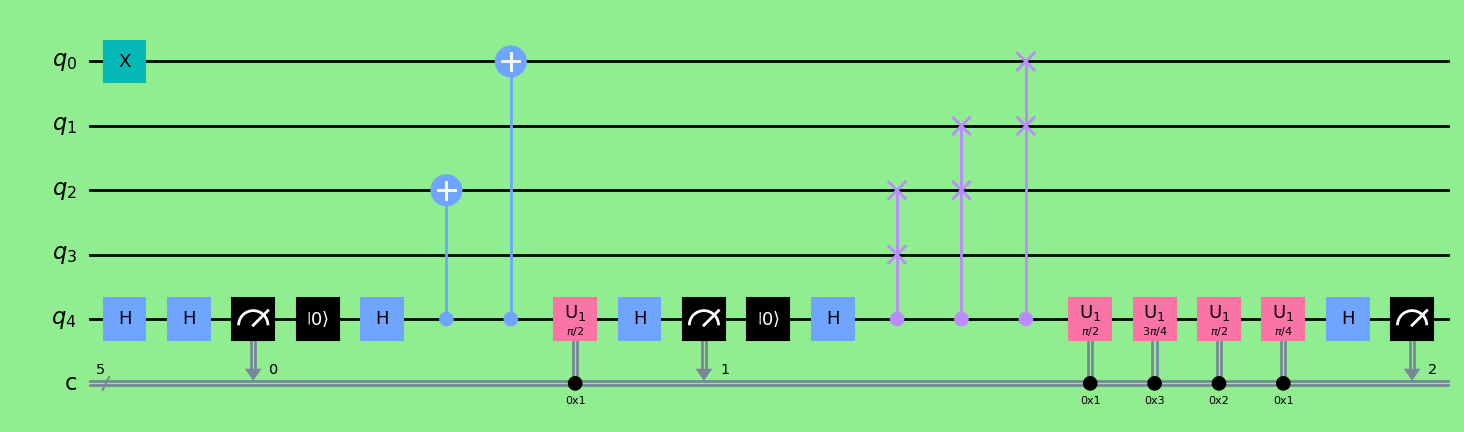

In [13]:
from qiskit.circuit.library.standard_gates import U1Gate

q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,2)
style = {'backgroundcolor': 'lightgreen'}
shor.draw(output='mpl', style=style)

In [14]:
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


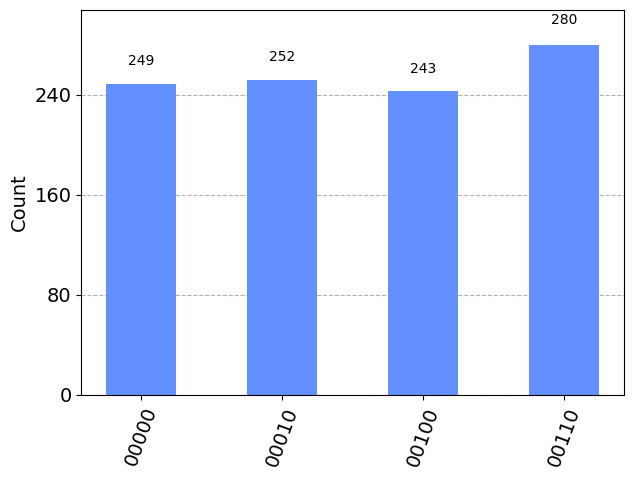

In [15]:
backend = BasicAer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor) 
plot_histogram(sim_data)

# Link to the documentation of Qiskit Aer to model noise --> https://qiskit.org/documentation/aer/device_noise_simulation.html

After the measurements are performed in the circuit, we observe that the outcomes x = 0, 2, 4, and 6 occur with equal probabilities, accounting for some noise. In typical cases, at this stage, the continued fraction expansion for x/2^k would be used. However, in this specific scenario where r divides q (the desired period), there is no need to employ the continued fraction expansion. We can simply compute ${p = GCD(a^{r/2} + 1, 15) = 5}$ and ${q = GCD(a^{r/2} - 1, 15) = 3}$.